In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint

import jax
import jax.numpy as jnp

### 1. Lorenz Data Generation

In [26]:
def lorenz(state, t, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Generate a Lorenz trajectory.
t = np.linspace(0, 40, 10_000)  # 10,000 time steps
initial_state = [1.0, 1.0, 1.0]
trajectory = odeint(lorenz, initial_state, t)  # shape: (10000, 3)

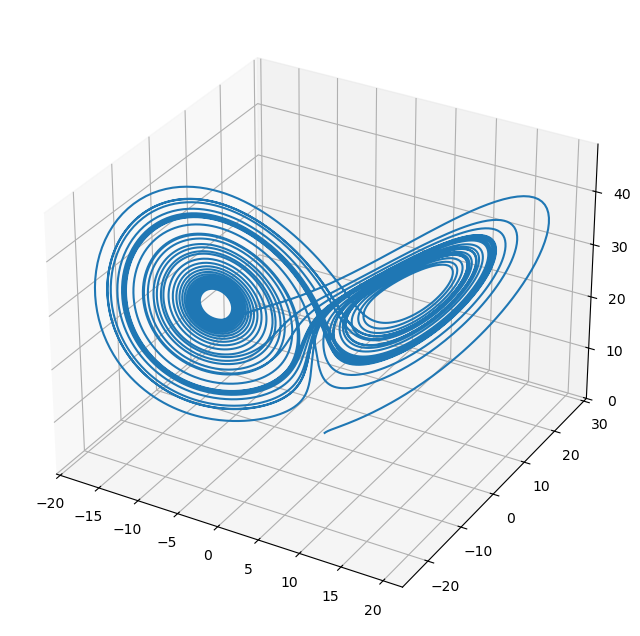

In [27]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2])

### 2. Dataset Preparation

In [28]:
sequence_length = 50  # Use 50 timesteps as input to predict the next state
X_list = []
y_list = []
for i in range(len(trajectory) - sequence_length):
    X_list.append(trajectory[i:i+sequence_length])
    y_list.append(trajectory[i+sequence_length])
X = np.array(X_list)  # shape: (num_samples, 50, 3)
y = np.array(y_list)  # shape: (num_samples, 3)

# Convert the dataset to JAX arrays.
X_jax = jnp.array(X)
y_jax = jnp.array(y)

In [29]:
X_jax.shape

(9950, 50, 3)


### 3. LSTM Model Definition in JAX

In an LSTM cell, the variables f, i, o, and g represent the activations of the different gates (and candidate) that control how information flows into and out of the cell. Here’s what each one does:

 - f (Forget Gate):

This gate determines which parts of the previous cell state should be forgotten (or retained). It produces values between 0 and 1 (using a sigmoid activation), where a value close to 0 means “forget this” and a value close to 1 means “keep this.” The forget gate is applied element-wise to the previous cell state.

 - i (Input Gate):

This gate controls which parts of the new candidate information should be added to the cell state. Like the forget gate, it produces values between 0 and 1 via a sigmoid function, effectively deciding how much new information to allow in.

 - g (Candidate Cell State):

Sometimes denoted as \tilde{c}, this variable represents the candidate values for updating the cell state. It is computed using a hyperbolic tangent (tanh) function, which squashes the values between -1 and 1. The candidate g is combined with the input gate i to determine what new information will be stored.

 - o (Output Gate):


This gate decides which parts of the updated cell state should be output as the hidden state for the current time step. It also produces values between 0 and 1 (via a sigmoid), and the final hidden state is computed by multiplying o with the tanh-transformed updated cell state.

In summary, during each LSTM step:
	1.	The forget gate f determines what to discard from the previous cell state.
	2.	The input gate i decides what portion of the new candidate g to add.
	3.	The cell state is updated by combining the forgotten old state with the scaled candidate.
	4.	The output gate o controls which parts of the new cell state are sent to the hidden state.

This gating mechanism allows the LSTM to maintain and update a memory over long sequences, helping it capture long-term dependencies in sequential data.

We'll implement a single-layer LSTM. For each time step, the cell performs:

    f = sigmoid(Wf x + Uf h + bf)
    i = sigmoid(Wi x + Ui h + bi)
    o = sigmoid(Wo x + Uo h + bo)
    g = tanh(Wc x + Uc h + bc)
    c_new = f * c + i * g
    h_new = o * tanh(c_new)

Then the final hidden state is passed through a linear layer to yield the prediction.

In [30]:



def lstm_cell(cell_params, h, c, x):
    f = jax.nn.sigmoid(jnp.dot(cell_params["Wf"], x) + jnp.dot(cell_params["Uf"], h) + cell_params["bf"])
    i = jax.nn.sigmoid(jnp.dot(cell_params["Wi"], x) + jnp.dot(cell_params["Ui"], h) + cell_params["bi"])
    o = jax.nn.sigmoid(jnp.dot(cell_params["Wo"], x) + jnp.dot(cell_params["Uo"], h) + cell_params["bo"])
    g = jnp.tanh(jnp.dot(cell_params["Wc"], x) + jnp.dot(cell_params["Uc"], h) + cell_params["bc"])
    c_new = f * c + i * g
    h_new = o * jnp.tanh(c_new)
    return h_new, c_new

def lstm_forward(lstm_params, inputs):
    # inputs shape: (sequence_length, input_dim)
    hidden_dim = lstm_params["Wf"].shape[0]
    h0 = jnp.zeros((hidden_dim,))
    c0 = jnp.zeros((hidden_dim,))
    def step(carry, x):
        h, c = carry
        h, c = lstm_cell(lstm_params, h, c, x)
        return (h, c), h
    (h_final, _), _ = jax.lax.scan(step, (h0, c0), inputs)
    return h_final

def model_forward(params, inputs):
    # inputs shape: (sequence_length, input_dim)
    h_final = lstm_forward(params["lstm"], inputs)
    # Linear layer: output = W_linear * h_final + b_linear.
    return jnp.dot(params["linear"]["W"], h_final) + params["linear"]["b"]

#### Parameter Initialization Functions

In [31]:
def init_lstm_params(key, input_dim, hidden_dim):
    keys = jax.random.split(key, 8)
    return {
        "Wf": jax.random.normal(keys[0], (hidden_dim, input_dim)) * 0.01,
        "Uf": jax.random.normal(keys[1], (hidden_dim, hidden_dim)) * 0.01,
        "bf": jnp.zeros((hidden_dim,)),
        "Wi": jax.random.normal(keys[2], (hidden_dim, input_dim)) * 0.01,
        "Ui": jax.random.normal(keys[3], (hidden_dim, hidden_dim)) * 0.01,
        "bi": jnp.zeros((hidden_dim,)),
        "Wo": jax.random.normal(keys[4], (hidden_dim, input_dim)) * 0.01,
        "Uo": jax.random.normal(keys[5], (hidden_dim, hidden_dim)) * 0.01,
        "bo": jnp.zeros((hidden_dim,)),
        "Wc": jax.random.normal(keys[6], (hidden_dim, input_dim)) * 0.01,
        "Uc": jax.random.normal(keys[7], (hidden_dim, hidden_dim)) * 0.01,
        "bc": jnp.zeros((hidden_dim,)),
    }

def init_linear_params(key, hidden_dim, output_dim):
    return {
        "W": jax.random.normal(key, (output_dim, hidden_dim)) * 0.01,
        "b": jnp.zeros((output_dim,))
    }

# Model dimensions.
input_dim = 3
hidden_dim = 64
output_dim = 3

# Initialize all parameters.
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
lstm_params = init_lstm_params(subkey, input_dim, hidden_dim)
key, subkey = jax.random.split(key)
linear_params = init_linear_params(subkey, hidden_dim, output_dim)
params = {"lstm": lstm_params, "linear": linear_params}

### 4. Training Setup

In [32]:
# Define the loss function (mean squared error). We use jax.vmap to process a batch.
def loss_fn(params, X_batch, y_batch):
    preds = jax.vmap(lambda x: model_forward(params, x))(X_batch)
    return jnp.mean((preds - y_batch) ** 2)

# Create an update step (using a simple gradient descent update).
learning_rate = 0.001

@jax.jit
def update(params, X_batch, y_batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, X_batch, y_batch)
    new_params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
    return new_params, loss

# Training hyperparameters.
num_samples = X_jax.shape[0]
batch_size = 64
num_epochs = 80

### 5. Training Loop

In [33]:
for epoch in range(num_epochs):
    # Shuffle indices.
    permutation = np.random.permutation(num_samples)
    X_shuffled = X_jax[permutation]
    y_shuffled = y_jax[permutation]
    epoch_loss = 0.0
    for i in range(0, num_samples, batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]
        params, loss_val = update(params, X_batch, y_batch)
        epoch_loss += loss_val * X_batch.shape[0]
    epoch_loss /= num_samples
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

Epoch 1/80, Loss: 89.741661
Epoch 2/80, Loss: 23.924234
Epoch 3/80, Loss: 10.278276
Epoch 4/80, Loss: 6.450469
Epoch 5/80, Loss: 4.426849
Epoch 6/80, Loss: 3.338288
Epoch 7/80, Loss: 2.413245
Epoch 8/80, Loss: 1.887040
Epoch 9/80, Loss: 1.608007
Epoch 10/80, Loss: 1.275177
Epoch 11/80, Loss: 1.010502
Epoch 12/80, Loss: 0.887761
Epoch 13/80, Loss: 0.754465
Epoch 14/80, Loss: 0.761178
Epoch 15/80, Loss: 0.672716
Epoch 16/80, Loss: 0.523762
Epoch 17/80, Loss: 0.505788
Epoch 18/80, Loss: 0.450462
Epoch 19/80, Loss: 0.452776
Epoch 20/80, Loss: 0.376741
Epoch 21/80, Loss: 0.378251
Epoch 22/80, Loss: 0.345189
Epoch 23/80, Loss: 0.303668
Epoch 24/80, Loss: 0.272465
Epoch 25/80, Loss: 0.259938
Epoch 26/80, Loss: 0.252974
Epoch 27/80, Loss: 0.221908
Epoch 28/80, Loss: 0.211015
Epoch 29/80, Loss: 0.218878
Epoch 30/80, Loss: 0.189572
Epoch 31/80, Loss: 0.195831
Epoch 32/80, Loss: 0.175526
Epoch 33/80, Loss: 0.177215
Epoch 34/80, Loss: 0.175149
Epoch 35/80, Loss: 0.159119
Epoch 36/80, Loss: 0.16184

### 6. Forecasting with the Trained Model

In [34]:
# Choose a segment near the end of the trajectory as a test sequence.
test_start = len(trajectory) - 200 - sequence_length
test_input_np = trajectory[test_start:test_start+sequence_length]  # shape: (50, 3)
test_target_np = trajectory[test_start+sequence_length:test_start+sequence_length+200]  # shape: (200, 3)

# Convert the initial test sequence to a JAX array.
current_seq = jnp.array(test_input_np)

predictions = []
for i in range(200):
    # Predict the next state from the current sequence.
    pred_state = model_forward(params, current_seq)
    predictions.append(pred_state)
    # Append the prediction to the sequence and drop the oldest state.
    current_seq = jnp.concatenate([current_seq[1:], pred_state[jnp.newaxis, :]], axis=0)
predictions = jnp.stack(predictions)

### 7. Visualization

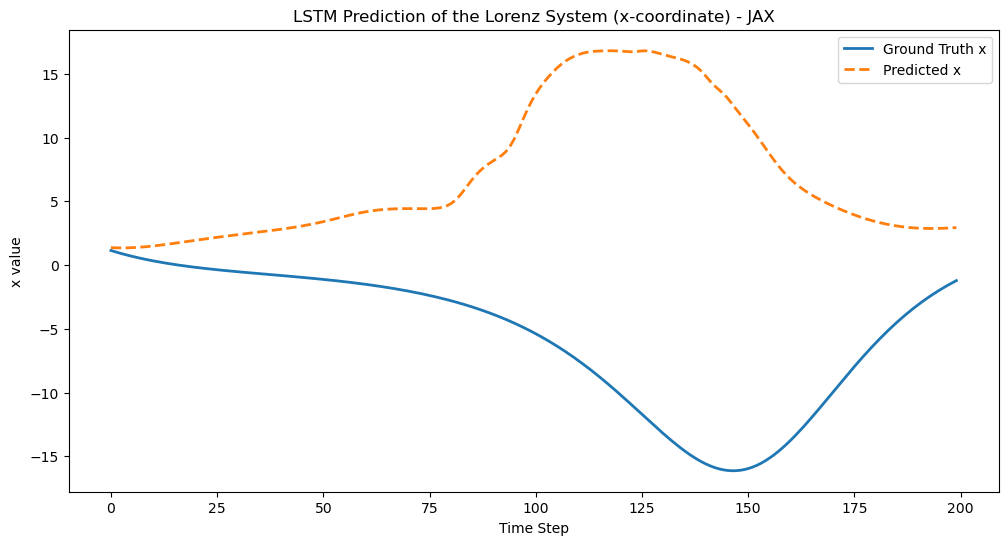

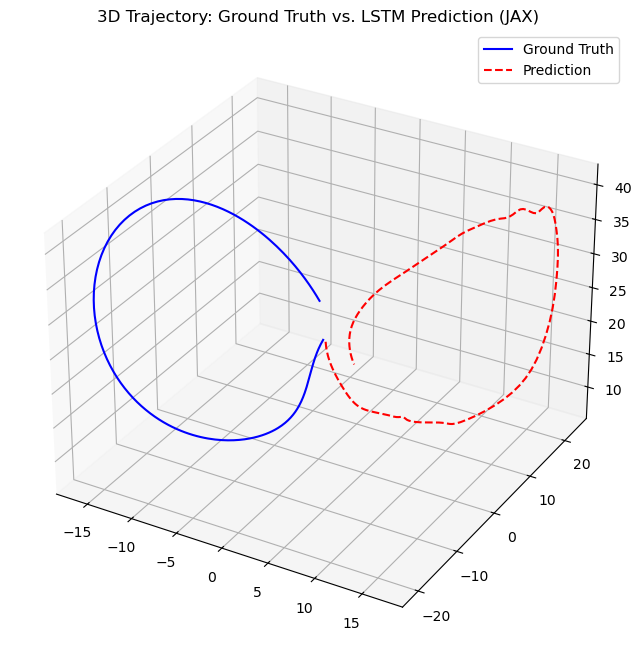

In [35]:
# Convert predictions and test targets to NumPy arrays for plotting.
predictions_np = np.array(predictions)
test_target_np = np.array(test_target_np)

# Plot the x-coordinate over the forecasting horizon.
plt.figure(figsize=(12, 6))
plt.plot(test_target_np[:, 0], label='Ground Truth x', linewidth=2)
plt.plot(predictions_np[:, 0], label='Predicted x', linestyle='--', linewidth=2)
plt.xlabel("Time Step")
plt.ylabel("x value")
plt.title("LSTM Prediction of the Lorenz System (x-coordinate) - JAX")
plt.legend()
plt.show()

# 3D Plot for the full trajectory.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_target_np[:, 0], test_target_np[:, 1], test_target_np[:, 2], label='Ground Truth', color='blue')
ax.plot(predictions_np[:, 0], predictions_np[:, 1], predictions_np[:, 2], label='Prediction', color='red', linestyle='--')
ax.set_title("3D Trajectory: Ground Truth vs. LSTM Prediction (JAX)")
ax.legend()
plt.show()